In [73]:
import pandas as pd
import csv
import plotly.graph_objects as go


In [74]:
class tsf:
    def __init__(self, tsf_path='', df=None, schema=None, timestep=None):
        self.tsf_path = tsf_path
        self.timestep = None
        self.dirty = False
        if tsf_path:
            with open(tsf_path) as f:
                csvreader = csv.reader(f, delimiter='\t')
                names = next(csvreader)[1:]
                func = next(csvreader)[1:]
                units = next(csvreader)[1:]
                if len(set(names)) != len(names):
                    raise TsfError('dumplicated names found in tsf file: %s' % names)
                schema = dict(zip(names, zip(func, units)))
            df = pd.read_csv(tsf_path, sep='\t', skiprows=[1, 2], index_col=0, parse_dates=True)
            self.df = df
            self.schema = schema
        else:
            self.schema = schema
            if df is None:
                df = pd.DataFrame()
            self.df = df

In [75]:
def scatter_plot(df, depth_fld, velocity_fld, depth_unit='in', velocity_unit='fps'):
    # https://github.com/plotly/plotly.py/issues/1445

    df = df.copy()
    df._velocity = df[velocity_fld]
    df._depth = df[depth_fld]
    fig = go.FigureWidget()
    trace1 = fig.add_scattergl(x=df._velocity, y=df._depth, mode='markers', name='points',
                             marker = dict(size=5,
                                           opacity=.5,
                                           color='#1f77b4',
                                           line = dict(width=1, color = '#1f77b4')
                                          )
                            )
    trace2 = fig.add_histogram(x=df._velocity, name='velocity', marker=dict(color='#1f77b4', opacity=0.7),
                          yaxis='y2'
                         )
    trace3 = fig.add_histogram(y=df._depth, name='depth', marker=dict(color='#1f77b4', opacity=0.7), 
                          xaxis='x2'
                         )
    fig.layout = dict(xaxis=dict(domain=[0, 0.85], showgrid=True, zeroline=False, title='Velocity(%s)' % velocity_unit),
                      yaxis=dict(domain=[0, 0.85], showgrid=True, zeroline=False, title='Depth(%s)' % depth_unit),
                      showlegend=False,
                      margin=dict(t=50),
                      hovermode='closest',
                      bargap=0,
                      xaxis2=dict(domain=[0.85, 1], showgrid=False, zeroline=False),
                      yaxis2=dict(domain=[0.85, 1], showgrid=False, zeroline=False),
                      height=600,
                      width=600,
                      title = 'Scatter Plot'
                     )

    def do_zoom(layout, xaxis_range, yaxis_range):
        inds = ((xaxis_range[0] <= flow.df._velocity) & (flow.df._velocity <= xaxis_range[1]) &
                (yaxis_range[0] <= flow.df._depth) & (flow.df._depth <= yaxis_range[1]))

        with fig.batch_update():
            trace2.x = flow.df._velocity[inds]
            trace3.y = flow.df._depth[inds]

    fig.layout.on_change(do_zoom, 'xaxis.range', 'yaxis.range')
    return fig

In [76]:
from plotly.subplots import make_subplots

def flow_plot(flow_df, rain_df, depth_fld, velocity_fld, rainfall_fld, flow_fld, depth_unit='in', 
              rainfall_unit='in/hr', flow_unit='mgd', velocity_unit='fps', start=None, end=None):
    
    rain_df = rain.df.copy()
    flow_df = flow.df.copy()
    if start:
        rain_df = rain_df[start:end]  
        flow_df = flow_df[start:end]
        
    
        
    rain_df['_rainfall'] = rain_df[rainfall_fld]
    flow_df['_flow'] = flow_df[flow_fld]
    flow_df['_depth'] = flow_df[depth_fld]
    flow_df['_velocity'] = flow_df[velocity_fld]
    fig = make_subplots(rows=3, cols=1, 
                        shared_xaxes=True, 
                        vertical_spacing=0.01,
                       row_heights=[0.2,0.4,0.4],
                       specs=[[{"secondary_y": False}],[{"secondary_y": True}], [{"secondary_y": False}]])

    fig.add_trace(go.Scatter(
        x = rain_df.index,
        y = rain_df.test,
        name = 'rainfall',
        line_shape='hv',
        fill='tozeroy',
        line=dict(color='blue', width=1)

    ) , row=1, col=1)

    fig.add_trace(go.Scatter(
        x = flow_df.index,
        y = flow_df._depth,
        name = 'Depth',
        line=dict(color='blue')
    ) , row=2, col=1)

    fig.add_trace(go.Scatter(
        x = flow_df.index,
        y = flow_df._velocity,
        name = 'Velocity',
        line=dict(color='green', dash='dot')

    ) , row=2, col=1, secondary_y=True)

    fig.add_trace(go.Scatter(
        x = flow_df.index,
        y = flow_df._flow,
        name = 'flow',
        line=dict(color='blue')
    ) , row=3, col=1)

    fig['layout']['yaxis1'].update(autorange="reversed", 
                                   title='Rainfall (%s)' % rainfall_fld)

    fig['layout']['yaxis2'].update(title='Depth(%s)' % depth_unit)
    fig['layout']['yaxis3'].update(title='Velocity(%s)' % velocity_unit)
    fig['layout']['yaxis4'].update(title='Flow(%s)' % flow_unit)




    fig.update_layout(
        height = 800, width=1200,
                      title_text="Flow Data Plot",
                     xaxis3_rangeslider_visible=True, 
                      xaxis3_rangeslider_thickness=0.1)
    
    return fig

# Scatter Plot Vel vs Depth

In [77]:
f = r"C:\Users\Mel.Meng\Desktop\test\flow.tsf"
flow = tsf(f)
scatter_plot(df=flow.df, depth_fld='_depth', velocity_fld='_velocity', depth_unit='in', velocity_unit='fps')

FigureWidget({
    'data': [{'marker': {'color': '#1f77b4', 'line': {'color': '#1f77b4', 'width': 1}, 'opacity…

# Flow monitoring Data Plot

In [78]:
f = r"C:\Users\Mel.Meng\Desktop\test\rainfall.tsf"
rain = tsf(f)
f = r"C:\Users\Mel.Meng\Desktop\test\flow.tsf"
flow = tsf(f)
fig = flow_plot(flow_df=flow.df, rain_df=rain.df, depth_fld='_depth', velocity_fld='_velocity', flow_fld='_flow', rainfall_fld='test', depth_unit='in', rainfall_unit='in/hr', flow_unit='mgd')

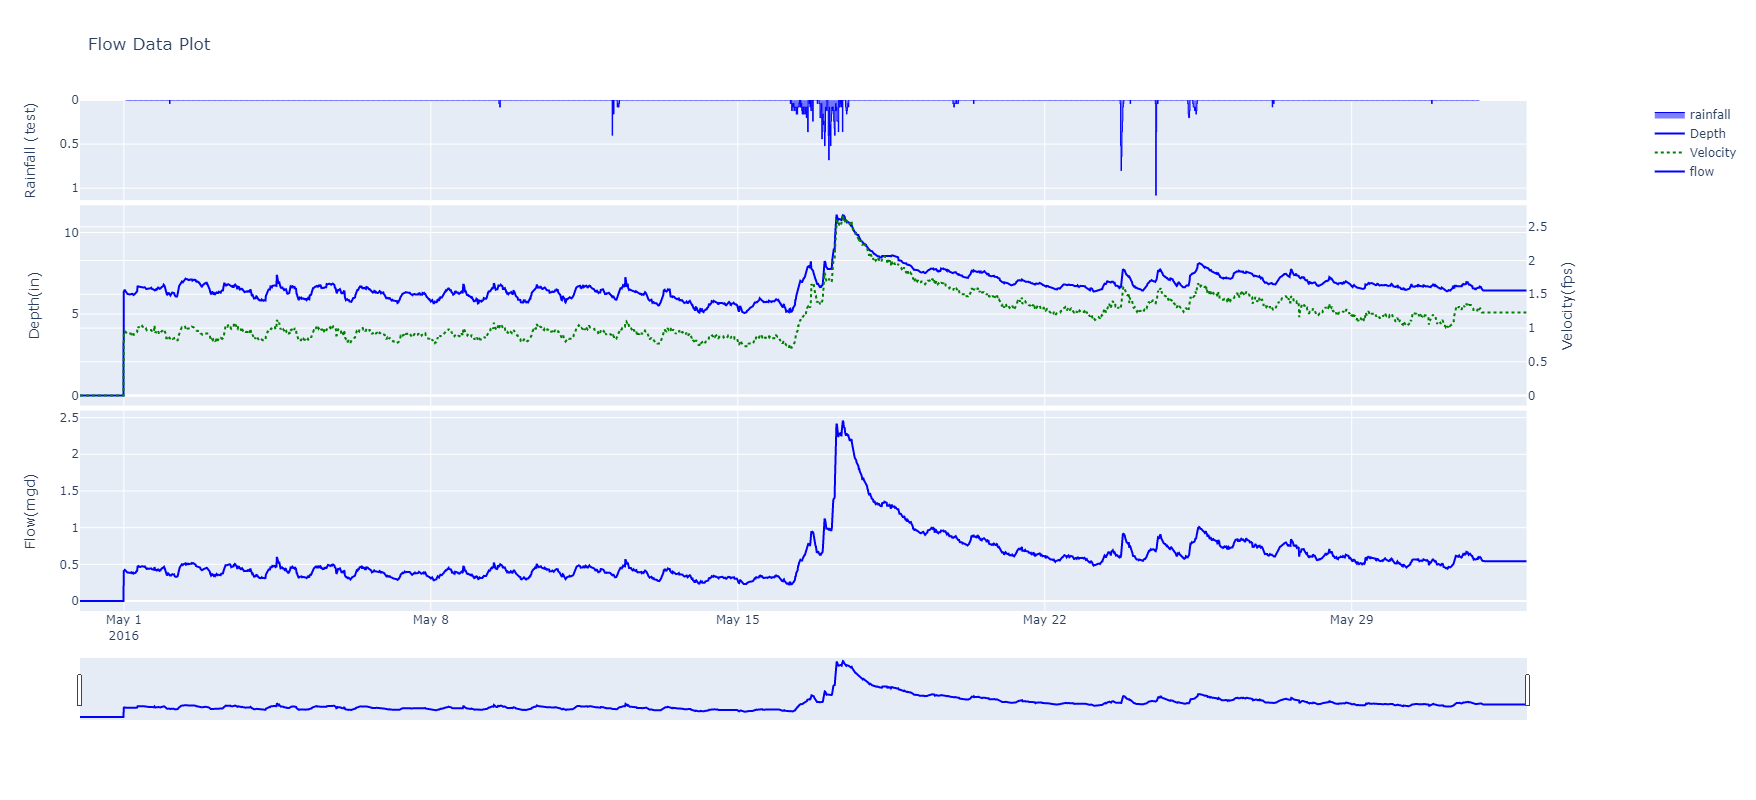

In [79]:
fig

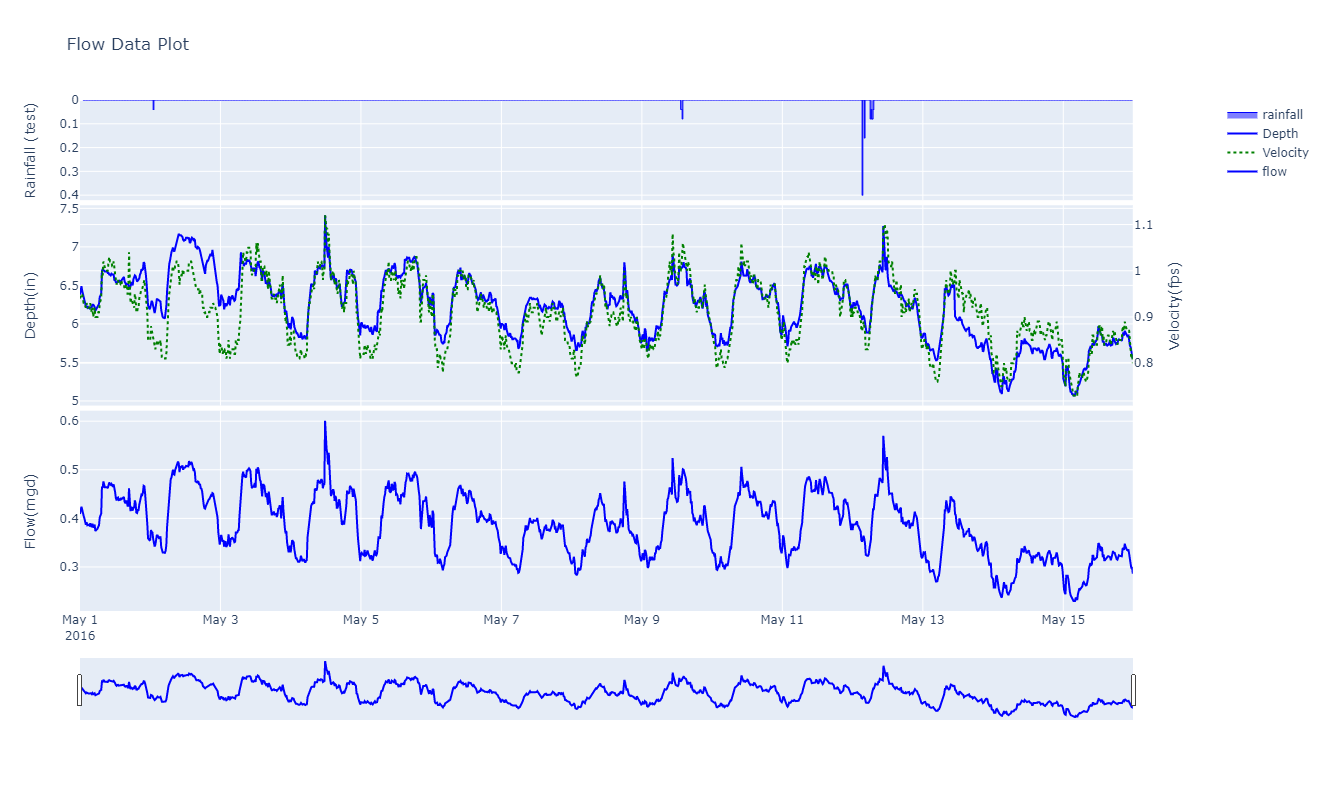

In [38]:
fig = flow_plot(flow_df=flow.df, rain_df=rain.df, depth_fld='_depth', 
                velocity_fld='_velocity', flow_fld='_flow', 
                rainfall_fld='test', depth_unit='in', rainfall_unit='in/hr', flow_unit='mgd',
               start='5/1/2016', end='5/15/2016')
fig

# DWF Flow Review

In [68]:
df = flow.df.copy()
df['dt'] = df.index
df['dow'] = df['dt'].apply(lambda x: x.strftime('%a'))
df['wkno'] = df['dt'].apply(lambda x: x.strftime('%U'))
df['time'] = df['dt'].apply(lambda x: x.time())
start='5/1/2016'
end='5/15/2016'
df = df[start:end]

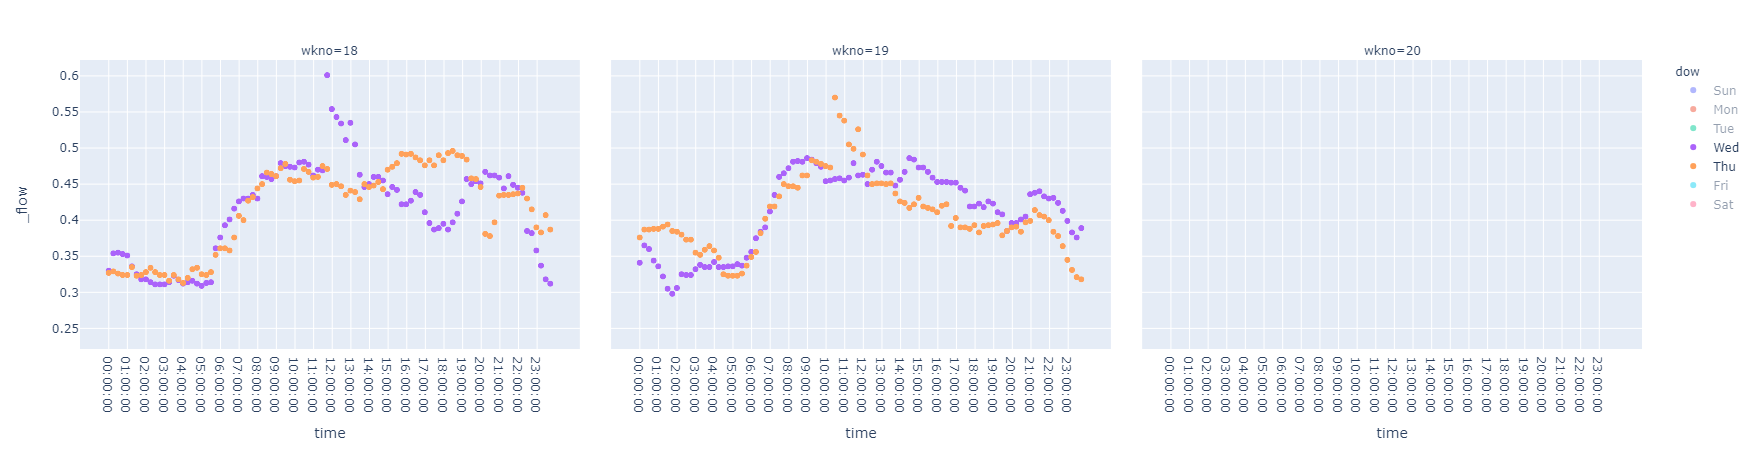

In [69]:
import plotly.express as px
fig = px.scatter(df, x='time', y='_flow', 
                facet_col='wkno', 
                 color='dow', facet_col_wrap=4)
fig

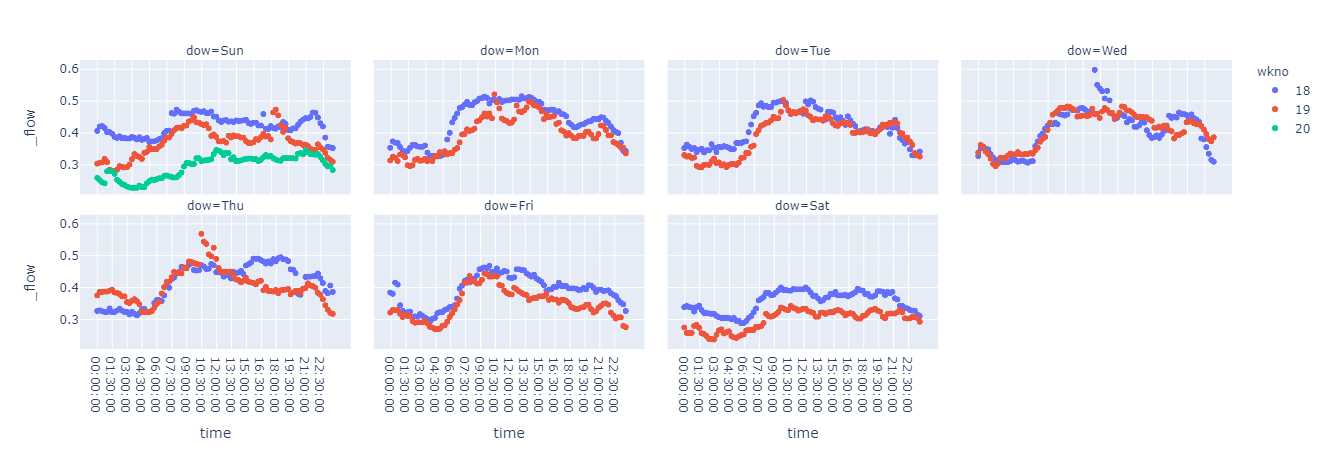

In [70]:
fig = px.scatter(df, x='time', y='_flow', 
                facet_col='dow', 
                 color='wkno', facet_col_wrap=4)
fig

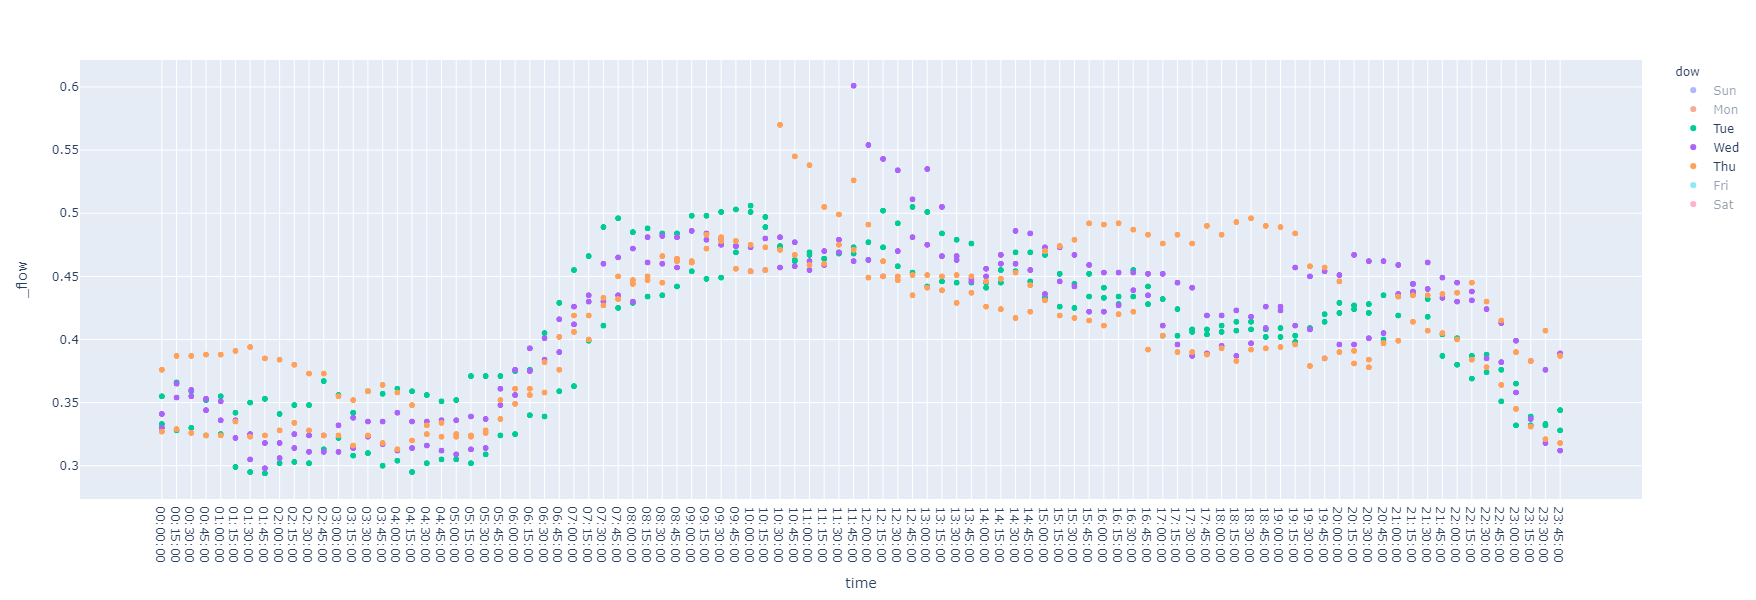

In [71]:
fig = px.scatter(df, x='time', y='_flow', 
#                  size='wkno', 
                 color='dow', facet_col_wrap=4, height=600, width=600)
fig

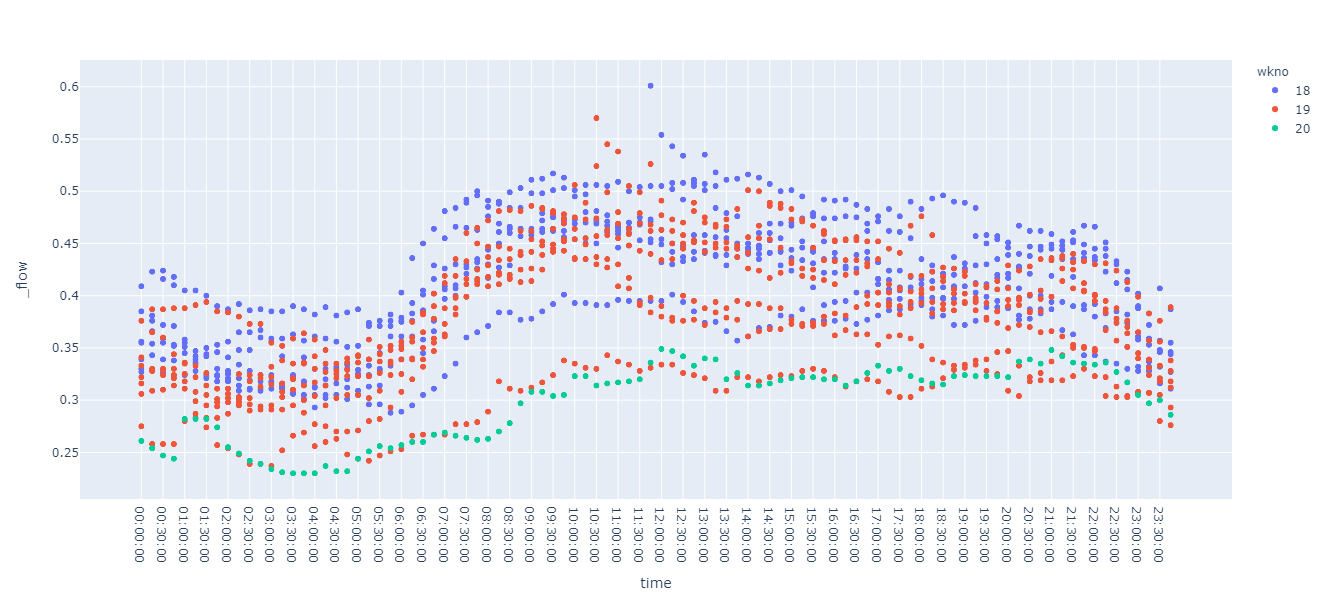

In [72]:
fig = px.scatter(df, x='time', y='_flow', 
#                  size='wkno', 
                 color='wkno', facet_col_wrap=4, height=600, width=600)
fig